In [1]:
import math
import pandas as pd
import scipy.io
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import networkx as nx
%matplotlib inline

mat = scipy.io.loadmat('isomap.mat')
df = pd.DataFrame(mat['images']).T
print(df.shape)
num_images, num_pixels = df.shape
# Rotate the pictures
for idx in df.index:
    df.loc[idx] = df.loc[idx].values.reshape(64, 64).T.reshape(-1)


(698, 4096)


In [2]:
# Calculate the threshold epsilon using Manhattan distance (at 100 neighbors)
def dist(a, b):
    return sum(abs(a - b))
distances = np.array([[dist(p1, p2) for p2 in df.values] for p1 in df.values])

# Keep only the 100 nearest neighbors, others set to 0. 
dist = distances.copy()
neighbors = np.zeros_like(distances)
sort_distances = np.argsort(distances, axis=1)[:, 1:101]

for k,i in enumerate(sort_distances):
    neighbors[k,i] = distances[k,i]

# Calculate the thrseshold epsilon when at least 100 neighbors
epsilon = np.max(neighbors) 
print(epsilon)

1009.6008272058828


In [3]:
# Create adjacent array A
from sklearn.neighbors import radius_neighbors_graph
A = radius_neighbors_graph(df.values, 1009.6, mode='connectivity', include_self=True).toarray()

C:\Users\Sealion\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


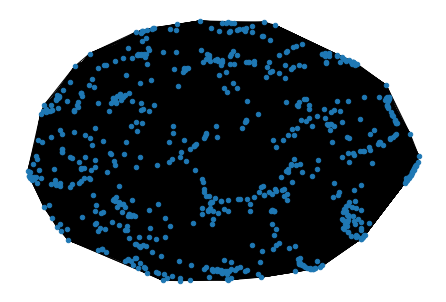

In [4]:
# Create similarity graph
import matplotlib.pyplot as plt
import networkx as nx

def show_graph(adjacency_matrix):
    rows, cols = np.where(adjacency_matrix == 1)
    edges = zip(rows.tolist(), cols.tolist())
    gr = nx.Graph()
    gr.add_edges_from(edges)
    nx.draw(gr, node_size=20)
    plt.show()
show_graph(A)

In [5]:
# ISOMAP
def isomap(X, n_components=2, dist=False):
    if not dist:
        # Compute distance matrix
        X, Y = distance_mat(X, n_neighbors)
    # Compute shortest paths (D) from distance matrix
    from sklearn.utils.graph import graph_shortest_path
    D = graph_shortest_path(X, directed=False)
    graph = -0.5 * (D ** 2)
    return MDS(graph)

In [6]:
def center(K):
    n_samples = K.shape[0]
    # Mean for each row/column
    meanrows = np.sum(K, axis=0) / n_samples
    meancols = (np.sum(K, axis=1)/n_samples)[:, np.newaxis]
    # Mean across all rows (entire matrix)
    meanall = meanrows.sum() / n_samples
    K -= meanrows
    K -= meancols
    K += meanall
    return K

In [7]:
# MDS projection on the shortest paths graph
def MDS(data, n_components=2):
    # Center distance matrix
    center(data)
    # Make a list of (eigenvalue, eigenvector) tuples
    eig_val_cov, eig_vec_cov = np.linalg.eig(data)
    eig_pairs = [(np.abs(eig_val_cov[i]), eig_vec_cov[:, i]) for i in range(len(eig_val_cov))]

    # Select n_components eigenvectors with largest eigenvalues, obtain subspace transform matrix
    eig_pairs.sort(key=lambda x: x[0], reverse=True)
    eig_pairs = np.array(eig_pairs)
    matrix_w = np.hstack([eig_pairs[i, 1].reshape(data.shape[1], 1) for i in range(n_components)])
    # Return samples in new subspace
    return matrix_w

In [8]:
# Perform Isomap
new_isomap = isomap(dist, dist=True)
print(new_isomap.shape)
type(new_isomap)

(698, 2)


numpy.ndarray

In [9]:
# Find three close points.
index = np.random.randint(0, num_images)
a = new_isomap[index,:]
# Calculate pairwise matrix

def distance_mat(X, n_neighbors=3):
    distances = np.array([sum(abs(a - b)) for b in X])
    sort_distances = np.argsort(distances) [:3]
    return new_isomap[sort_distances,:]

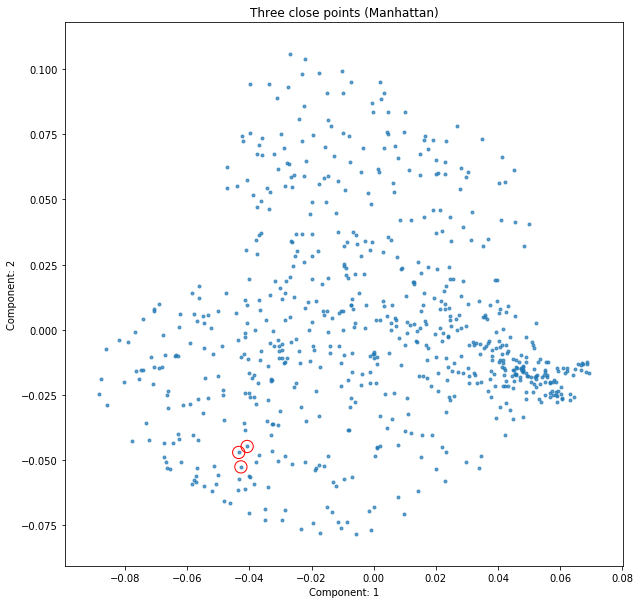

In [10]:
fig = plt.figure()
fig.set_size_inches(10, 10)
ax = fig.add_subplot(111)
ax.scatter(new_isomap[:,0], new_isomap[:,1] , marker='.',alpha=0.7)
plt.scatter(distance_mat(new_isomap)[0][0], distance_mat(new_isomap)[0][1], marker='o', facecolors='none', edgecolors='r', s=150)
plt.scatter(distance_mat(new_isomap)[1][0], distance_mat(new_isomap)[1][1], marker='o', facecolors='none', edgecolors='r', s=150)
plt.scatter(distance_mat(new_isomap)[2][0], distance_mat(new_isomap)[2][1], marker='o', facecolors='none', edgecolors='r', s =150) 
plt.title("Three close points (Manhattan)")
ax.set_xlabel('Component: 1')
ax.set_ylabel('Component: 2')
plt.show()


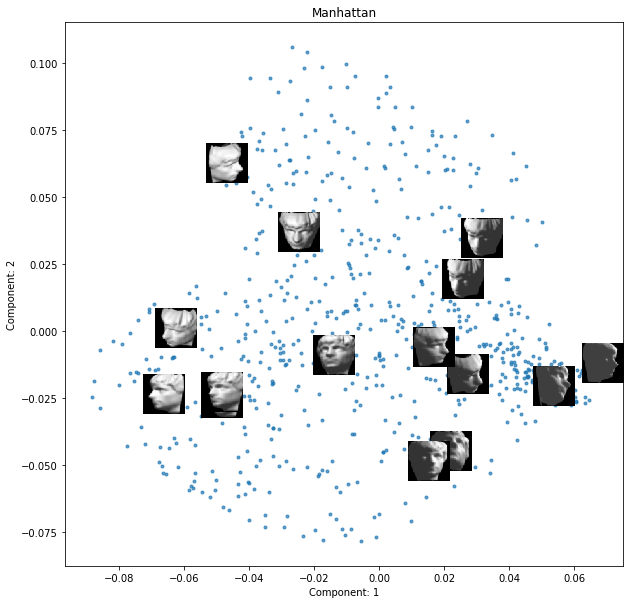

In [17]:
# Figrue setup
fig = plt.figure()
fig.set_size_inches(10, 10)
ax = fig.add_subplot(111)
ax.set_title('Manhattan')
ax.set_xlabel('Component: 1')
ax.set_ylabel('Component: 2')
new_2D = pd.DataFrame(new_isomap)
#Show 15 of the images ont the plot
x_size = (max(new_2D[0]) - min(new_2D[0])) * 0.08
y_size = (max(new_2D[1]) - min(new_2D[1])) * 0.08
for i in range(15):
    img_num = np.random.randint(0, num_images)
    x0 = new_2D.loc[img_num, 0] - (x_size / 2.)
    y0 = new_2D.loc[img_num, 1] - (y_size / 2.)
    x1 = new_2D.loc[img_num, 0] + (x_size / 2.)
    y1 =new_2D.loc[img_num, 1] + (y_size / 2.)
    img = df.iloc[img_num,:].values.reshape(64, 64)
    ax.imshow(img, aspect='auto', cmap=plt.cm.gray, 
              interpolation='nearest', zorder=100000, extent=(x0, x1, y0, y1))

#Show 2D components plot
ax.scatter(new_2D[0], new_2D[1], marker='.',alpha=0.7)
plt.show()